<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY-9163-ML-cyber/blob/main/Lab/MLSec_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE-GY 9163 ML Cyber Lab1-Email spam filtering

## Overview

In this lab, you will design an e-mail spam filter using a Naive Bayes and SVM based classification on the ling-spam dataset. You will explore the impact of feature selection and compare the performance of different variants of an NB classifier and also implement your own SVM based classifier. (Note: You may use the scikitt learn classifiers to only compare the accuracy
of their model to yours).

## Dataset

The ling-spam corpus contains e-mails from the Linguist mailing list categorized as either legitimate or spam emails. The corpus is divided into four sub-folders that contain the same emails that are pre-processed with/without lemmatization and with/without stop-word removal. The e-mails in each sub-folder partitioned into 10 "folds."

In this lab, we will use the first 9 folds from the ling-spam corpus as training data, and the $10^{th}$ fold as test data.

## What you have to do

You will implement your e-mail spam filters in Python. You are free to use any Python libraries that are relevant to the problem.

* Download the ling-spam dataset from http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz

Please use the "lingspam_public01' corpus with both lemmatization and stop-word enabled (under the lemm_stop folder).

* Your first goal is to perform feature selection using the information gain (IG) metric. From the training data, select the top-N features for N = {10, 100, 1000}. Note that feature selection based on the IG metric only accounts for the occurrence of (and not frequency with which terms appear) in the dataset.

* Next, implement the following classifiers:
  * Bernoulli NB classifier with binary features;
  * Multinomial NB with binary features, and
  * Multinomial NB with term frequency (TF) features.

* For each of the three classifiers above and for N = {10, 100, 1000} report the spam precision and spam recall. Spam precision is defined as the fraction of true spam e-mails among all e-mails predicted as spam, and spam recall is defined as fraction of true spam e-mails predicted as spam. Also report the latency of each model.
* Design a Support Vector Machine (SVM) based spam filter. This problem is open ended: for instance, you can choose to use either BF or TF and any feature selection method. Note that you should NOT use the test dataset in picking the hyper-parameters of your spam filter, instead use cross-validation on the training dataset.

Finally, we covered "Adversarial Classification" (https://dl.acm.org/citation.cfm?id=1014066), an approach to update NB based e-mail spam filters in response to attacks that try to evade a basic NB filter. You are expected to implement the techniques presented in this paper. More specifically, you can make the following assumptions:
* The baseline NB classifier uses the **top-10** terms identified using the IG metric and using Boolean features.
* The adversary uses the **ADD-WORDS** strategy. Adding a term to an email incurs unit cost. The attacker seeks to find the minimum cost solution such that each spam email in the test set gets classified as legitimate by the baseline NB classifier.
* Update the baseline NB classifier in response to the attacker's strategy above. You can assume that the defender
pays a unit price for both false positives and false negatives.

## What to submit

* Your Python code in the form of a Google Colab notebook. Please also include a PDF of your colab notebook.
* Your Colab notebook should print:
* a list of the top-10 words identified from Part (1) above, and
* a list of spam precision and spam recall values for each of the three classifiers for N = {10, 100, 1000}. That is, your list should have 9 rows, one for each classifier and N combination.
* For the SVM based spam filter, please describe your methodology, i.e., what kind of features you used, how many features you used and how you selected them, the parameters of the SVM and finally the precision and recall on
the test dataset.
* For Your Neural network model, please report on the model design, input parameters, number of layers, number
of neurons in each layer and finally the accuracy and latency of the model.
* For the adversarial attack, report the False Negative rate of the baseline NB classifier before and after the attacker's modifications to test emails. Also, report the average "cost of the attacker's modifications, averaged
over all spam emails in the test set. Finally, report the False Negative and False Positive rate of the updated NBclassifier.

## Import packages

In [69]:
import numpy as np
import pandas as pd
import tarfile
import os
import string
import re
import operator
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

## Load dataset and process data

Here, we will use files that under lemm_stop folder

In [2]:
!wget "http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz" -O lingspam_public.tar.gz

--2021-10-24 23:17:04--  http://www.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www.aueb.gr (www.aueb.gr)... 195.251.255.156
Connecting to www.aueb.gr (www.aueb.gr)|195.251.255.156|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz [following]
--2021-10-24 23:17:05--  http://www2.aueb.gr/users/ion/data/lingspam_public.tar.gz
Resolving www2.aueb.gr (www2.aueb.gr)... 195.251.255.138
Connecting to www2.aueb.gr (www2.aueb.gr)|195.251.255.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11564714 (11M) [application/x-gzip]
Saving to: ‘lingspam_public.tar.gz’

lingspam_public.tar 100%[===================>]  11.03M  1.21MB/s    in 12s     

2021-10-24 23:17:18 (953 KB/s) - ‘lingspam_public.tar.gz’ saved [11564714/11564714]



In [ ]:
!tar -xvzf "lingspam_public.tar.gz"

Lemmatisation: Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. n many languages, words appear in several inflected forms. For example, in English, the verb 'to walk' may appear as 'walk', 'walked', 'walks' or 'walking'. The base form, 'walk', that one might look up in a dictionary, is called the lemma for the word. The association of the base form with a part of speech is often called a lexeme of the word.

We will use the lemm_stop dataset. There are 10 folders totally. We need to count how many spam emails and how many ham email. We will use it later to calculate the probability

In [4]:
lemm_stop = ['lingspam_public/lemm_stop/part1/', 'lingspam_public/lemm_stop/part2/', 'lingspam_public/lemm_stop/part3/',
             'lingspam_public/lemm_stop/part4/', 'lingspam_public/lemm_stop/part5/', 'lingspam_public/lemm_stop/part6/',
             'lingspam_public/lemm_stop/part7/', 'lingspam_public/lemm_stop/part8/', 'lingspam_public/lemm_stop/part9/',
             'lingspam_public/lemm_stop/part10/']

processData function will process all txt data. The function will return a nested dict finally. It will remove all "\n","\t" and all punctuation such as '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'. Finally, the txt data will become a list. For example: ['hello','world']. For each email, it will be put to a nest fict. Here, we have 10 folders totally, the final result for this function is 

{
  
"lingspam_public/lemm_stop/part1":

{
  
"3-565msg2.txt":[],

"3-1msg1.txt":[],...

}

}



In [5]:
def processData(dir_list):
  all_data = {}
  for dir in dir_list:
     all_data[dir]={} # a nested dict
     file_list = os.listdir(dir) # list all files in a dir   
     for file_name in file_list: # go through all files   
        f = open(dir+file_name, "r")
        data = f.read()
        data = data.lower() # make all letters to lowercase
        data = data.replace('\n','') # remove all next_line
        data = data.replace('\t','') # remove all tag
        data = data.replace("subject",'') # remove subject, it exists all emails, that is why we remove it.
        data = re.sub(r"\d+", "", data) # remove numbers, for example, "123abc" -> "abc"
        punctuation_string = string.punctuation # remove all punctuation such as !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
        for i in punctuation_string:
          data = data.replace(i,'')
        data = data.split(' ')
        data = ' '.join(data).split()
        
        all_data[dir][file_name] = data # add to dict
        f.close()
  return all_data

In [6]:
all_data = processData(lemm_stop)

In [7]:
## Show one example here to see what does data look like
## print one list
print(all_data['lingspam_public/lemm_stop/part10/']['9-878msg1.txt'])

['conf', 'computerm', 'workshop', 'colingacl', 'computerm', 'workshop', 'announcement', 'first', 'workshop', 'computational', 'terminology', 'august', 'after', 'colingacl', 'where', 'university', 'montreal', 'montreal', 'quebec', 'canada', 'http', 'tornade', 'ere', 'umontreal', 'ca', 'lhommem', 'cole', 'computerm', 'html', 'context', 'workshop', 'provide', 'forum', 'bring', 'together', 'researcher', 'field', 'computational', 'linguistics', 'terminology', 'automate', 'translation', 'information', 'retrieval', 'lexicography', 'share', 'interest', 'computational', 'aspect', 'terminology', 'process', 'acquisition', 'extraction', 'index', 'machineaid', 'thesaurus', 'build', 'dictionary', 'construction', 'etc', 'registration', 'number', 'participant', 'workshop', 'limit', 'advisable', 'preregister', 'soon', 'possible', 'http', 'colingacl', 'iro', 'umontreal', 'ca', 'fee', 'html', 'additional', 'information', 'travel', 'accomodation', 'tourism', 'colingacl', 'conference', 'main', 'page', 'htt

We need to get the feature list

In [8]:
def getFeatureList(dir_list, all_data):
  feature_list = []
  for dir in dir_list:
    file_list = os.listdir(dir) # list all files in a dir  
    for file_name in file_list: # go through all files   
      for item in all_data[dir][file_name]:
        if item not in feature_list:
          feature_list.append(item)
  return feature_list

In [9]:
feature_list = getFeatureList(lemm_stop, all_data)

In [10]:
print("we have {} features in total.".format(len(feature_list)))

we have 53207 features in total.


We already process data. We need to separate spam email and ham email list

In [20]:
def separateSpamAndHam(dir_list, all_data):
  spam_email_dict = {}
  ham_email_dict = {}
  for dir in dir_list:
    file_list = os.listdir(dir) # list all files in a dir  
    for file_name in file_list: # go through all files
      
      if 'spm' in file_name:
        spam_email_dict[file_name]=all_data[dir][file_name]
      else:
        ham_email_dict[file_name]=all_data[dir][file_name]
  return spam_email_dict, ham_email_dict

In [21]:
spam_email_dict, ham_email_dict = separateSpamAndHam(lemm_stop, all_data)

In [47]:
print(spam_email_dict)

{'spmsga11.txt': ['challengedesk', 'robert', 'g', 'allen', 'dear', 'nlpeople', 'first', 'let', 'ask', 'question', 'want', 'build', 'extra', 'stream', 'income', 'yes', 'let', 'show', 'begin', 'live', 'dream', 'instead', 'wait', 'until', 's', 'too', 'late', 'interest', 'please', 'forgive', 'intrusion', 'delete', 'letter', 'contact', 'again', 'letterhead', 'name', 'robert', 'allen', 'm', 'book', 'nothe', 'down', 'creat', 'wealth', 'york', 'best', 'seller', 'recent', 'audio', 'program', 'road', 'wealth', 'multiple', 'stream', 'income', 'accord', 'independent', 'research', 'book', 'program', 'create', 'hundred', 'millionaire', 'third', 'book', 'call', 'challenge', 's', 'true', 'story', 'select', 'woman', 'unemployment', 'line', 'teach', 'success', 'secret', 'ninety', 'day', 'later', 'earn', 'earn', 'm', 'work', 'next', 'challenge', 'call', 'multiple', 'stream', 'income', 'challenge', 'here', 's', 'challenge', 'test', 'select', 'small', 'group', 'teach', 'brand', 'earn', 'extra', 'stream', '

## Information gain calculation

We can measure "information" which measures the reduction in entropy or surprise by splitting a dataset according to a given value of a random variable.Here, it is a bernoulli process and the result has two variables $X\in \{0,1\}$ where 0 is ham email and 1 is spam email. We assume that $P(X=1)=p$. We can calculate H(X). The formula is below
$$
H(X)=-plog(p)-(1-p)log(1-p)
$$
where $p$ is the prior probability of spam email. 

So we need to count how many spam and ham emails in the dataset.


In [23]:
def countTheNumberOfHamAndSpam(dir_list):
  count_spam = 0
  count_ham = 0
  for dir in dir_list:
    file_list = os.listdir(dir) # list all files in a dir 
    for file_name in file_list: 
      if 'spm' in file_name:
        count_spam+=1
      else:
        count_ham+=1
  return count_spam, count_ham

In [24]:
count_spam, count_ham = countTheNumberOfHamAndSpam(lemm_stop)

In [25]:
## print out the number of spam and ham emails
print("We have {} spam emails, and {} ham emails totally".format(count_spam, count_ham))

We have 481 spam emails, and 2412 ham emails totally


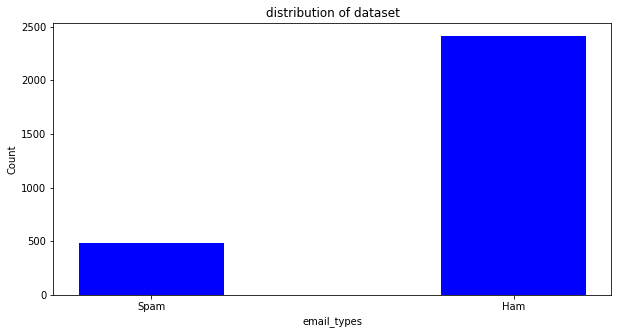

In [26]:
# creating the dataset
d_value = {'Spam':481, 'Ham':2412}
email_types = list(d_value.keys())
values = list(d_value.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(email_types, values, color ='blue',
        width = 0.4)
 
plt.xlabel("email_types")
plt.ylabel("Count")
plt.title("distribution of dataset")
plt.show()

For each word, we need to count how many spam emails containing the word and how many ham emails containing the same word. We need to use these numbers to calculate the probability later. We already separate spam and ham email above. We got two dicts and we can go through them and count.

In [27]:
def countWordsInSpamAndHam(wordSet, dict):
  word_count = {}
  for word in wordSet:
    count = 0
    for key in dict:
      if word in dict[key]:
        count+=1
    word_count[word] = count
  return word_count 

In [28]:
spam_word_count = countWordsInSpamAndHam(feature_list, spam_email_dict)
ham_word_count = countWordsInSpamAndHam(feature_list, ham_email_dict)

In [29]:
print(len(ham_word_count))

53207


Here, we can calculate H(X). We probably need to use Laplacian smoothing here because we need to calculate the probability.

In [30]:
p_spam = (count_spam+1)/(count_spam+count_ham+2)
H_p_spam = -p_spam*np.log(p_spam)-(1-p_spam)*np.log((1-p_spam))
print("The H(X) is {}:".format(H_p_spam))

The H(X) is 0.45028313289981026:


For a specific word, we can calculate the information gain too. The formula is 
$$
IG(C,X_i)=H(C)-H(C|X_i)
$$

We have calculated $H(C)$ above, which is H(X). And the larger $IG(C,X_i)$, the better classified variable 

Here, we need to calculate $H(C|X_i)$.

We have the formula
$$
\begin{gathered}
H(C|X_i)=-\sum_x P(X_i=x)H(C|X=x)\\
=\sum_{x,c}P(X_i=x,C=c)log(P(C=x|X_i=x)\\
=\sum_{c\in \{\text{spam, legit}\}} \sum_{x\in \{0,1\}}P(X_i=x,C=c)log(P(C=x|X_i=x))
\end{gathered}
$$

where $P(X_i=x,C=c)=P(X_i=x|C=c)\times P(C=c)$

and $P(C=x|X_i=x)=\frac{P(X_i=x|C=c)\times P(C=c)}{P(X_i=x)}$

Here, $P(X_i=x)$ means, for example, when $P(X_i=0)$, it means how manny emails that do not contain the word divide by total number of emails.

Let's explain this.

for example

we need to calculate $H(C|x_i)$. Then we have
$$
\begin{gathered}
H(C|x_i)=P(c=spam,x_i=0)\times log(P(c=spam|x_i=0))\\
+P(c=spam,x_i=1)\times log(P(c=spam|x_i=1))\\
+P(c=ham,x_i=0)\times log(P(c=ham|x_i=0))\\
+P(c=ham,x_i=1)\times log(P(c=ham|x_i=1))
\end{gathered}
$$

When we calculate IG, we need to use Lapalcian smoothing.

In [31]:
def calIGForEachWord(wordSet, count_ham, count_spam, spam_word_count, ham_word_count, H_p_spam):
  IG_dict = {} # to record IG for each word
  for word in wordSet:
    total = count_ham + count_spam # total number of emails
    spam_word = spam_word_count[word] # numer of spam emails contain this specific word
    ham_word = ham_word_count[word] # numer of ham emails contain this specific word

    IG_word = (-1) * (((count_spam-spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2)) * 
                      np.log(((count_spam-spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2))/((total-spam_word-ham_word+1)/(total+2))) # P(c=spam, x=0) log(P(c=spam|x=0))
                  + ((spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2)) * 
                      np.log(((spam_word+1)/(count_spam+2)) * ((count_spam+1)/(total+2))/((spam_word+ham_word+1)/(total+2))) # P(c=spam, x=1) log(P(c=spam|x=1))
                  + ((count_ham-ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2)) *
                      np.log(((count_ham-ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2))/((total-spam_word-ham_word+1)/(total+2))) # P(c=ham, x=0) log(P(c=ham|x=0))
                  + ((ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2)) * 
                      np.log(((ham_word+1)/(count_ham+2)) * ((count_ham+1)/(total+2))/((spam_word+ham_word+1)/(total+2)))) # P(c=ham, x=1) log(P(c=ham|x=1))
      
    IG_dict[word] = H_p_spam - IG_word # H(C) - H(C|X_i)
  return IG_dict     

In [32]:
IG_dict = calIGForEachWord(feature_list, count_ham, count_spam, spam_word_count, ham_word_count, H_p_spam)

After we calculate the IG for each word, we need to sort them in descending order. We need to select the larger value.

In [33]:
IG_dict_sorted = dict(sorted(IG_dict.items(), key=operator.itemgetter(1),reverse=True))

Here, we will select top {10, 100, 1000} words based on the IG calculation result.

In [34]:
top_10_words = {}
top_100_words = {}
top_1000_words = {}

i=0
j=0
k=0
for key in IG_dict_sorted.keys():
  if i<10:
    i+=1
    top_10_words[key] = IG_dict_sorted[key]
  
  if j<100:
    j+=1
    top_100_words[key] = IG_dict_sorted[key]
  
  if k<1000:
    k+=1
    top_1000_words[key] = IG_dict_sorted[key]

In [35]:
# print out top 10 words and check their IG values
for key in top_10_words.keys():
  print(key, top_10_words[key])

language 0.14326012650087844
remove 0.11330213365324149
free 0.10568069639925093
university 0.10561860619065228
linguistic 0.10286155209981812
money 0.07516328678905015
click 0.06857733773076702
our 0.05895458386952379
today 0.05450011637777258
sell 0.05364248242586378


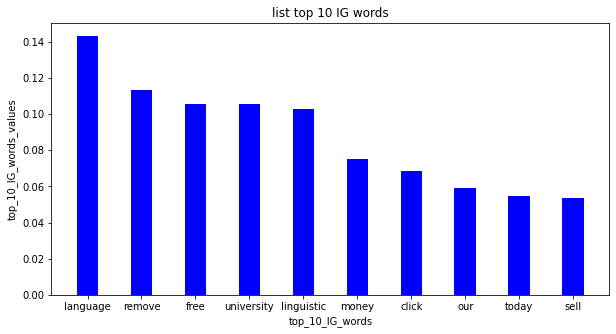

In [52]:
# We can also visualize them
top_10_IG_words = list(top_10_words.keys())
top_10_IG_words_values = list(top_10_words.values())

top_100_IG_words = list(top_100_words.keys())
top_1000_IG_words = list(top_1000_words.keys())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(top_10_IG_words, top_10_IG_words_values, color ='blue',
        width = 0.4)
 
plt.xlabel("top_10_IG_words")
plt.ylabel("top_10_IG_words_values")
plt.title("list top 10 IG words")
plt.show()

## Implement classifiers

Here, we need to implement three NB classifiers.

  * Bernoulli NB classifier with binary features;
  * Multinomial NB with binary features, and
  * Multinomial NB with term frequency (TF) features.

### Build data
Before we build the classifers, we need to get the train data and test data. We need to create both binary features and feature frequency features. We need to create top {10, 100, 1000} features.

In [37]:
train_lemm_stop = lemm_stop[0:9]
test_lemm_stop = ['lingspam_public/lemm_stop/part10/']
print(test_lemm_stop)

['lingspam_public/lemm_stop/part10/']


In [38]:
def generateData(top_N_words, email_dict):
  feature_list = []
  if top_N_words==10:
    feature_list = list(top_10_words.keys())
  elif top_N_words==100:
    feature_list = list(top_100_words.keys())
  else:
    feature_list = list(top_1000_words.keys())

  data = []
  for key in email_dict.keys():
    temp_dict = dict.fromkeys(feature_list, 0)
    for word in email_dict[key]:
      if word in feature_list:
        temp_dict[word] = 1

    if 'spm' in key:
      temp_dict['label'] = 1
    else:
      temp_dict['label'] = 0
    data.append(temp_dict)
  return data    

In [39]:
train_spam_email_dict, train_ham_email_dict = separateSpamAndHam(train_lemm_stop, all_data)
test_spam_email_dict, test_ham_email_dict = separateSpamAndHam(test_lemm_stop, all_data)

Create top {10, 100, 1000} binary features

In [44]:
# top 10
train_data_10_binary_feature = generateData(10, train_spam_email_dict) + generateData(10, train_ham_email_dict)
test_data_10_binary_feature = generateData(10, test_spam_email_dict) + generateData(10, test_ham_email_dict)

# top 100
train_data_100_binary_feature = generateData(100, train_spam_email_dict) + generateData(100, train_ham_email_dict)
test_data_100_binary_feature = generateData(100, test_spam_email_dict) + generateData(100, test_ham_email_dict)

# top 1000
train_data_1000_binary_feature = generateData(1000, train_spam_email_dict) + generateData(1000, train_ham_email_dict)
test_data_1000_binary_feature = generateData(1000, test_spam_email_dict) + generateData(1000, test_ham_email_dict)

In [45]:
print(len(train_data_binary_feature))

2602


In [49]:
df_train_binary = pd.DataFrame.from_dict(train_data_binary_feature)
df_train_binary.head()

,language,remove,free,university,linguistic,money,click,our,today,sell,label
0,0,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,1
3,0,0,0,0,0,1,0,0,1,0,1
4,0,1,0,0,0,0,0,0,0,0,1


### Bernoulli NB with binary features

For Bernoulli NB with binary features, we have m attributes $F=\{t_1,\cdots, t_m\}$ in the dataset. We need to calculate the probability of occurace of each word, which is $p(t_i|c)$. For each message, we can get
$$
p(\overrightarrow{x}|c)=\prod_{i=1}^m p(t_i|c)^{x_i} (1-p(t_i|c))^{(1-x_i)}
$$

where $x_i\in \{0,1\}$, which means occur or not.

And the formula of judging the message is spam or not is shown below:
$$
\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}(1-p(t_i|c_s))^{(1-x_i)}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}(1-p(t_i|c))^{(1-x_i)}}>T
$$

where $T$ is the threshold. But we do not know the threshold here. We probably can calculate a ratio here.

$$
\begin{gathered}
\frac{\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}(1-p(t_i|c_s))^{(1-x_i)}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}(1-p(t_i|c))^{(1-x_i)}}}{\frac{p(c_h)\prod_{i=1}^m p(t_i|c_h)^{x_i}(1-p(t_i|c_h))^{(1-x_i)}}{\sum_{c\in \{c_s,c_h\}}p(c)\prod_{i=1}^m p(t_i|c)^{x_i}(1-p(t_i|c))^{(1-x_i)}}}=\frac{p(c_s)\prod_{i=1}^m p(t_i|c_s)^{x_i}(1-p(t_i|c_s))^{(1-x_i)}}{p(c_h)\prod_{i=1}^m p(t_i|c_h)^{x_i}(1-p(t_i|c_h))^{(1-x_i)}}
\end{gathered}
$$
If the ratio is greater than 1, then it is a spam, less than otherwise. The way we calculate $p(t|c)$ is 
$$
p(t|c)=\frac{1+M_{t,c}}{2+M_c}
$$

We need to apply Laplacian smoothing here when we calculate it.

Here, $M_{t,c}$ means in class $c$, how many emails contain token $t$. $M_c$ means how many emails are in class $c$

In [54]:
def BernoulliNBWithBinaryFeatures(top_N_features, email, numOfSpam, numOfHam, spam_word_count, ham_word_count):
  p_spam = (numOfSpam+1)/(numOfSpam+numOfHam+2)
  p_ham = (numOfHam+1)/(numOfSpam+numOfHam+2)

  p_spam_numerator = 1
  p_ham_denumerator = 1
  for i, x_i in enumerate(email):
    p_word_given_spam = (1+spam_word_count[top_N_features[i]])/(2+numOfSpam)
    p_word_given_ham = (1+ham_word_count[top_N_features[i]])/(2+numOfHam)

    p_spam_numerator = p_spam_numerator * np.power(p_word_given_spam, x_i) * np.power((1-p_word_given_spam), (1-x_i))
    p_ham_denumerator = p_ham_denumerator * np.power(p_word_given_ham, x_i) * np.power((1-p_word_given_ham), (1-x_i))

  pred = p_spam_numerator/p_ham_denumerator

  if pred>1:
    return 1 # 1 is spam
  else:
    return 0 # 0 is ham

Top 10 features

In [ ]:
test_data_10_binary_feature_list = []
for item in test_data_10_binary_feature:
  test_data_10_binary_feature_list.append(list(item.values()))

In [73]:
test_data_10_binary_feature_pred_result = []
test_data_10_binary_feature_true_label = []
for email in test_data_10_binary_feature_list:
  test_data_10_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_10_IG_words, email[0:9], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_10_binary_feature_true_label.append(email[-1])

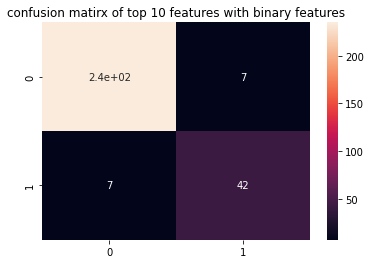

In [74]:
cf_matrix = confusion_matrix(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result)
plt.title("confusion matirx of top 10 features with binary features") 
sns.heatmap(cf_matrix, annot=True)

In [76]:
acc_top_10_bernoulli = accuracy_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result)
recall_top_10_bernoulli = recall_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result, average='binary')
precision_top_10_bernoulli = precision_score(test_data_10_binary_feature_true_label, test_data_10_binary_feature_pred_result, average='binary')

print("The accuracy of bernoulli NB classifier is {}".format(acc_top_10_bernoulli))
print("The spam recall is {}".format(recall_top_10_bernoulli))
print("The spam precision is {}".format(precision_top_10_bernoulli))

The accuracy of bernoulli NB classifier is 0.9518900343642611
The spam recall is 0.8571428571428571
The spam precision is 0.8571428571428571


Top 100 features

In [77]:
test_data_100_binary_feature_list = []
for item in test_data_100_binary_feature:
  test_data_100_binary_feature_list.append(list(item.values()))

In [86]:
test_data_100_binary_feature_pred_result = []
test_data_100_binary_feature_true_label = []
for email in test_data_100_binary_feature_list:
  test_data_100_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_100_IG_words, email[0:99], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_100_binary_feature_true_label.append(email[-1])

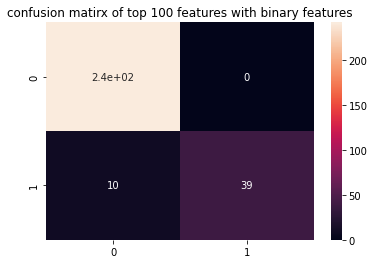

In [87]:
cf_matrix = confusion_matrix(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result)
plt.title("confusion matirx of top 100 features with binary features") 
sns.heatmap(cf_matrix, annot=True)

In [88]:
acc_top_100_bernoulli = accuracy_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result)
recall_top_100_bernoulli = recall_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result, average='binary')
precision_top_100_bernoulli = precision_score(test_data_100_binary_feature_true_label, test_data_100_binary_feature_pred_result, average='binary')

print("The accuracy of bernoulli NB classifier is {}".format(acc_top_100_bernoulli))
print("The spam recall is {}".format(recall_top_100_bernoulli))
print("The spam precision is {}".format(precision_top_100_bernoulli))

The accuracy of bernoulli NB classifier is 0.9656357388316151
The spam recall is 0.7959183673469388
The spam precision is 1.0


top 1000 features

In [82]:
test_data_1000_binary_feature_list = []
for item in test_data_1000_binary_feature:
  test_data_1000_binary_feature_list.append(list(item.values()))

In [89]:
test_data_1000_binary_feature_pred_result = []
test_data_1000_binary_feature_true_label = []
for email in test_data_1000_binary_feature_list:
  test_data_1000_binary_feature_pred_result.append(BernoulliNBWithBinaryFeatures(top_1000_IG_words, email[0:999], count_spam, count_ham, spam_word_count, ham_word_count))
  test_data_1000_binary_feature_true_label.append(email[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


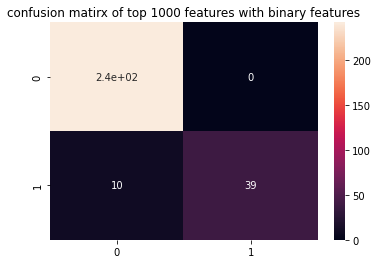

In [90]:
cf_matrix = confusion_matrix(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result)
plt.title("confusion matirx of top 1000 features with binary features") 
sns.heatmap(cf_matrix, annot=True)

In [91]:
acc_top_1000_bernoulli = accuracy_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result)
recall_top_1000_bernoulli = recall_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result, average='binary')
precision_top_1000_bernoulli = precision_score(test_data_1000_binary_feature_true_label, test_data_1000_binary_feature_pred_result, average='binary')

print("The accuracy of bernoulli NB classifier is {}".format(acc_top_1000_bernoulli))
print("The spam recall is {}".format(recall_top_1000_bernoulli))
print("The spam precision is {}".format(precision_top_1000_bernoulli))

The accuracy of bernoulli NB classifier is 0.9656357388316151
The spam recall is 0.7959183673469388
The spam precision is 1.0


### Multinomial NB with binary features

### Multinomial NB with term frequency (TF) features

## SVM classifier